## Modélisation du prix du m² à bordaux (année2022) pour les logements de 4 pièces, Séparation appartements vs maisons

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

## Chargement des données 

In [2]:
# Configuration des graphiques
plt.style.use('default')
sns.set_palette('husl')

def load_and_explore_data():
    """ Charger les données de Bordeaux"""
    print(" Chargement des données de Bordeaux...")
    
    df = pd.read_csv("../data/bordeaux_2022.csv")
    print(f" Données chargées : {len(df)} transactions")
    
    # Explorer les colonnes disponibles
    print(" Colonnes disponibles :")
    for i, col in enumerate(df.columns, 1):
        print(f"  {i:2d}. {col}")
    
    # Vérifier les types de logements
    if 'Type local' in df.columns:
        print(f" Types de logements :")
        print(df['Type local'].value_counts())
    
    # Vérifier les nombres de pièces
    if 'Nombre pieces principales' in df.columns:
        print(f" Répartition nombre de pièces :")
        print(df['Nombre pieces principales'].value_counts().sort_index())
    
    return df

# Appel de  la fonction pour charger et explorer les données
df_bdx = load_and_explore_data()

 Chargement des données de Bordeaux...


FileNotFoundError: [Errno 2] No such file or directory: '../data/bordeaux_2022.csv'

## Filtrage

In [ ]:
# Appel de  la fonction pour charger et explorer les données
df_bdx = load_and_explore_data()

# Puis filtrer sur 4 pièces
df_bdx_4p = df_bdx[df_bdx['Nombre pieces principales'] == 4].copy()

# PUIS créer les variables appartements/maisons
appartements = df_bdx_4p[df_bdx_4p['Type local'] == 'Appartement'].copy()
maisons = df_bdx_4p[df_bdx_4p['Type local'] == 'Maison'].copy()



print(f" Appartements 4 pièces : {len(appartements)}")
print(f" Maisons 4 pièces : {len(maisons)}")


In [44]:
from sklearn.model_selection import train_test_split  

#   Définir la fonction de nettoyage
def select_features_and_clean(df, dataset_name):
    """Sélectionner les colonnes et nettoyer"""
    print(f" Nettoyage données {dataset_name}...")
    
    if len(df) == 0:
        print(f" Aucune donnée pour {dataset_name}")
        return None, None, None
    
    # Colonnes à conserver
    required_cols = ['Surface reelle bati', 'Nombre pieces principales', 'Type local', 'Valeur fonciere']
    optional_cols = ['Surface terrain', 'Nombre de lots']
    
    # Vérifier colonnes disponibles
    available_cols = [col for col in required_cols if col in df.columns]
    available_optional = [col for col in optional_cols if col in df.columns]
    
    print(f" Colonnes disponibles : {available_cols + available_optional}")
    
    # Sélectionner et nettoyer
    selected_cols = available_cols + available_optional
    df_clean = df[selected_cols].copy()
    
    # Créer prix_m2 (Variable cible)
    df_clean['prix_m2'] = df_clean['Valeur fonciere'] / df_clean['Surface reelle bati']
    print(f" Variable prix_m2 créée")
    
    # Nettoyage
    print(f" Avant nettoyage : {len(df_clean)} lignes")
    
    # Remplacer valeurs manquantes 
    if 'Surface terrain' in df_clean.columns:
        df_clean['Surface terrain'] = df_clean['Surface terrain'].fillna(0)
    if 'Nombre de lots' in df_clean.columns:
        df_clean['Nombre de lots'] = df_clean['Nombre de lots'].fillna(1)
    
    # Supprimer lignes avec données essentielles manquantes
    df_clean = df_clean.dropna(subset=['Surface reelle bati', 'Valeur fonciere'])
    print(f" Après nettoyage valeurs manquantes : {len(df_clean)} lignes")
    
    # Identifier et retirer les valeurs aberrantes (prix au m²)
    if len(df_clean) > 0:
        Q1 = df_clean['prix_m2'].quantile(0.25)
        Q3 = df_clean['prix_m2'].quantile(0.75)
        IQR = Q3 - Q1
        
        # Limites pour les outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        print(f" Détection outliers prix_m2 :")
        print(f" Q1: {Q1:.2f}, Q3: {Q3:.2f}")
        print(f" Limites: [{lower_bound:.2f}, {upper_bound:.2f}]")
        
        # Filtrer les outliers
        mask = (df_clean['prix_m2'] >= lower_bound) & (df_clean['prix_m2'] <= upper_bound)
        df_clean = df_clean[mask]
        
        print(f" Après suppression outliers : {len(df_clean)} lignes")
    
    if len(df_clean) == 0:
        print(f" Plus de données après nettoyage pour {dataset_name}")
        return None, None, None
    
    # Préparer X et y
    feature_cols = [col for col in df_clean.columns if col not in ['Valeur fonciere', 'prix_m2', 'Type local']]
    X = df_clean[feature_cols]
    y = df_clean['prix_m2']
        
    # Afficher quelques statistiques
    print(f"-Statistiques {dataset_name} :")
    print(f"-Prix m² min: {df_clean['prix_m2'].min():.2f} €")
    print(f"-Prix m² max: {df_clean['prix_m2'].max():.2f} €")
    print(f"-Prix m² moyen: {df_clean['prix_m2'].mean():.2f} €")
    print(f"-Variables : {list(X.columns)}")
    
    return X, y, df_clean

# Appeler la fonction
print("\n=== NETTOYAGE APPARTEMENTS ===")
x_bdx_apt, y_bdx_apt, df_apt_clean = select_features_and_clean(appartements, "APPARTEMENTS")

print("\n=== NETTOYAGE MAISONS ===")
x_bdx_maisons, y_bdx_maisons, df_maisons_clean = select_features_and_clean(maisons, "MAISONS")






=== NETTOYAGE APPARTEMENTS ===
 Nettoyage données APPARTEMENTS...
 Colonnes disponibles : ['Surface reelle bati', 'Nombre pieces principales', 'Type local', 'Valeur fonciere', 'Surface terrain', 'Nombre de lots']
 Variable prix_m2 créée
 Avant nettoyage : 663 lignes
 Après nettoyage valeurs manquantes : 663 lignes
 Détection outliers prix_m2 :
 Q1: 3344.83, Q3: 5279.63
 Limites: [442.64, 8181.82]
 Après suppression outliers : 606 lignes
-Statistiques APPARTEMENTS :
-Prix m² min: 876.74 €
-Prix m² max: 8174.07 €
-Prix m² moyen: 4177.57 €
-Variables : ['Surface reelle bati', 'Nombre pieces principales', 'Surface terrain', 'Nombre de lots']

=== NETTOYAGE MAISONS ===
 Nettoyage données MAISONS...
 Colonnes disponibles : ['Surface reelle bati', 'Nombre pieces principales', 'Type local', 'Valeur fonciere', 'Surface terrain', 'Nombre de lots']
 Variable prix_m2 créée
 Avant nettoyage : 408 lignes
 Après nettoyage valeurs manquantes : 408 lignes
 Détection outliers prix_m2 :
 Q1: 4470.62, Q3

## Préparation de données bordeaux 

In [ ]:
print("\n" + "=" * 60)
print(" PRÉPARATION DES DONNÉES BORDEAUX")
print("=" * 60)

# Préparer les données pour chaque type
x_bdx_apt, y_bdx_apt, df_apt_clean = select_features_and_clean(appartements, "APPARTEMENTS")
x_bdx_maisons, y_bdx_maisons, df_bdx_maisons_clean = select_features_and_clean(maisons, "MAISONS")

print("\n Données Bordeaux préparées !")
print(f" Appartements Bordeaux : {len(x_bdx_apt) if x_bdx_apt is not None else 0} échantillons")
print(f" Maisons Bordeaux : {len(x_bdx_maisons) if x_bdx_maisons is not None else 0} échantillons")



## Visualisation de la distribution de prix

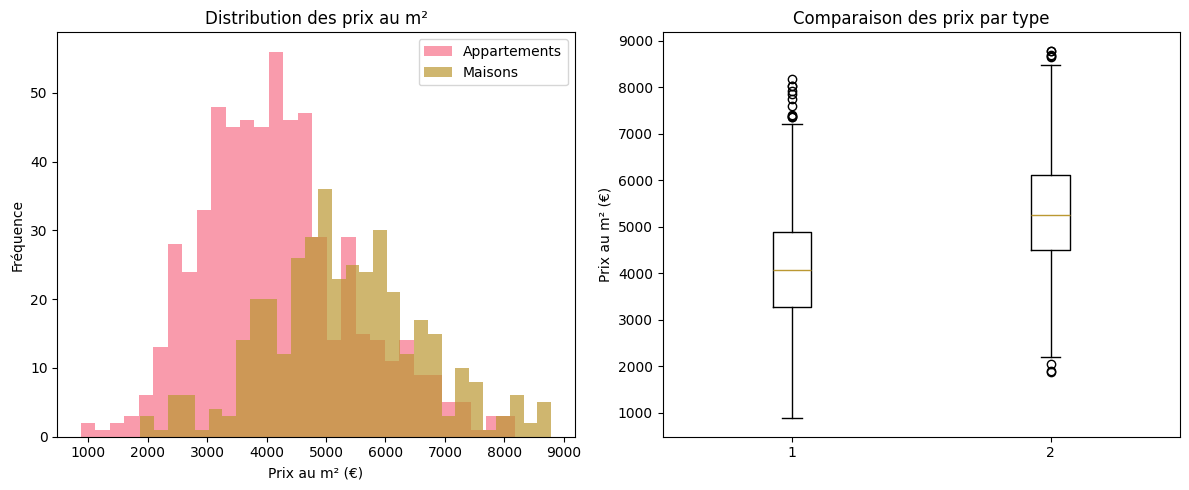

In [43]:
# Comparer les distributions de prix
if df_apt_clean is not None and df_maisons_clean is not None:
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(df_apt_clean['prix_m2'], bins=30, alpha=0.7, label='Appartements')
    plt.hist(df_maisons_clean['prix_m2'], bins=30, alpha=0.7, label='Maisons')
    plt.xlabel('Prix au m² (€)')
    plt.ylabel('Fréquence')
    plt.title('Distribution des prix au m²')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.boxplot([df_apt_clean['prix_m2'], df_maisons_clean['prix_m2']], 
                label=['Appartements', 'Maisons'])
    plt.ylabel('Prix au m² (€)')
    plt.title('Comparaison des prix par type')
    plt.tight_layout()
    plt.show()

## Import des modèle entrainé  pour lille 

In [ ]:
import joblib

# Chargement des modèles
lr_apt = joblib.load('../models/lille_appartements.pkl')
lr_maisons = joblib.load('../models/lille_maisons.pkl')
scaler_apt = joblib.load('../models/scaler_lille_apt.pkl')
scaler_maisons = joblib.load('../models/scaler_lille_maisons.pkl')

print(" Modèles chargés")

## 

In [41]:
#  Test avec standardisation
if x_bdx_apt is not None and y_bdx_apt is not None:
    print(" Standardisation Bordeaux avec scaler Lille...")
    
    # Standardisation de  Bordeaux avec le scaler de Lille
    x_bdx_apt_scaled = scaler_apt.transform(x_bdx_apt)
    
    # Prédiction avec données standardisées
    print(" Test modèle Lille → Bordeaux Appartements (STANDARDISÉ)")
    y_pred_bdx_scaled = lr_apt.predict(x_bdx_apt_scaled)
    
    # Métriques
    mse_bordeaux_scaled = mean_squared_error(y_bdx_apt, y_pred_bdx_scaled)
    rmse_bordeaux_scaled = np.sqrt(mse_bordeaux_scaled)
    r2_bordeaux_scaled = r2_score(y_bdx_apt, y_pred_bdx_scaled)
    
    print(f"MSE Bordeaux:  {mse_bordeaux_scaled:>12,.2f}")
    print(f"RMSE Bordeaux: {rmse_bordeaux_scaled:>12,.2f} €/m²")
    print(f"R² Bordeaux: {r2_bordeaux_scaled:>12.3f}")
    
    # Comparaison
    print(f"\n Comparaison :")
    print(f" MSE SANS standardisation: 1,336,055,724")
    print(f" MSE AVEC standardisation: {mse_bordeaux_scaled:,.2f}")
    
else:
    print("Pas de données Bordeaux")


appartements_results = {}
maisons_results = {}

# Stocke le résultat
if 'mse_bordeaux_scaled' in locals():
    appartements_results['LinearRegression_Standardisé'] = mse_bordeaux_scaled

print(f"\nRésultats collectés: {appartements_results}")

 Standardisation Bordeaux avec scaler Lille...
 Test modèle Lille → Bordeaux Appartements (STANDARDISÉ)
   MSE Bordeaux:  2,127,422.62
   RMSE Bordeaux:     1,458.57 €/m²
   R² Bordeaux:         -0.327

 Comparaison :
   MSE SANS standardisation: 1,336,055,724
   MSE AVEC standardisation: 2,127,422.62

Résultats collectés: {'LinearRegression_Standardisé': 2127422.619700383}


In [42]:
def display_results_comparison(appartements_results, maisons_results):
    """ Affichage du  tableau comparatif"""
    print("\n" + "="*60)
    print(" TABLEAU COMPARATIF DES PERFORMANCES (MSE)")
    print("="*60)
    
    # Créer un DataFrame pour l'affichage
    models = set(appartements_results.keys()) | set(maisons_results.keys())
    
    comparison_data = []
    for model in models:
        apt_mse = appartements_results.get(model, 'N/A')
        maison_mse = maisons_results.get(model, 'N/A')
        
        comparison_data.append({
            'Modèle': model,
            'Appartements (MSE)': f"{apt_mse:.2f}" if apt_mse != 'N/A' else 'N/A',
            'Maisons (MSE)': f"{maison_mse:.2f}" if maison_mse != 'N/A' else 'N/A'
        })
    
    df_comparison = pd.DataFrame(comparison_data)
    print(df_comparison.to_string(index=False))
    
    # Identifiecation  des meilleurs modèles
    if appartements_results:
        best_apt_model = min(appartements_results, key=appartements_results.get)
        print(f"\n Meilleur modèle APPARTEMENTS : {best_apt_model} (MSE: {appartements_results[best_apt_model]:.2f})")
    
    if maisons_results:
        best_maison_model = min(maisons_results, key=maisons_results.get)
        print(f" Meilleur modèle MAISONS : {best_maison_model} (MSE: {maisons_results[best_maison_model]:.2f})")

display_results_comparison(appartements_results, maisons_results)




 TABLEAU COMPARATIF DES PERFORMANCES (MSE)
                      Modèle Appartements (MSE) Maisons (MSE)
LinearRegression_Standardisé         2127422.62           N/A

 Meilleur modèle APPARTEMENTS : LinearRegression_Standardisé (MSE: 2127422.62)
